In [2]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import torchsummary
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.cuda.amp import GradScaler, autocast

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold

import sys
sys.path.append('../DataLoader')

from dataloader import SunImageDataset


from lightning.fabric import Fabric

In [3]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch()
print(fabric.device)

Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0


In [4]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
num_epochs = 20
batch_size = 2
learning_rate = 0.001
# dropout = 0.6990787087509548

In [5]:
dataset = SunImageDataset(csv_file="D:\\dataset.csv", offset=0, transform=transforms.ToTensor())
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Without Validation Set
trainset, testset = torch.utils.data.Subset(dataset, range(train_size)), torch.utils.data.Subset(dataset, range(train_size, len(dataset)))
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=10)

trainloader = fabric.setup_dataloaders(trainloader)

# # With Validation Set
# # Split dataset into training and test sets
# train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, shuffle=False)

# # Further split training set into training and validation sets
# train_indices, val_indices = train_test_split(train_indices, test_size=0.25, shuffle=False)  # 0.25 x 0.8 = 0.2

# trainset = torch.utils.data.Subset(dataset, train_indices)
# valset = torch.utils.data.Subset(dataset, val_indices)
# testset = torch.utils.data.Subset(dataset, test_indices)

# trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
# valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=batch_size, shuffle=False)


# # Get a batch of training data
# dataiter = iter(trainloader)
# images, labels = next(dataiter)
# images = torch.stack(images)
# print(images.shape)
# print(labels.shape)

# print(images)
# print(labels)

In [6]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()
        
        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)
        
        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )
        
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(hidden_size*10, hidden_size),
            nn.Dropout(p=0.5),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            nn.LeakyReLU()
        )
    
    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """
        # # Print input shape for debugging
        # # print("Input shape:", images.shape)
        # image_features = torch.zeros(images.shape[0],images.shape[1], hidden_size).to(device)
        # for i in range(images.shape[0]):
        #     image = images[i, :, :, :]
        #     # Pretrained swin transformer accepts three channel images
        #     three_channel = torch.stack([image,image,image], dim=1).squeeze(2)
        #     # print("three_channel", three_channel.size())
        #     # Model learns optimal initial normalisation
        #     normalized_images = self.bn(three_channel)
        #     # Get image features
        #     image_feature = self.pretrained_model.forward(normalized_images)
        #     image_features[i] = image_feature
        # # print("image_features before reshaping", image_features.size())
        # image_features = image_features.view(image_features.size(0), -1)
        # print("image_features after reshaping", image_features.size())
        
        batch_size = images.shape[0]
        
        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, -1)
        
        output = self.fc(image_features)
        return output

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model, optimizer = fabric.setup(model, optimizer)
model.train()

_FabricModule(
  (_forward_module): GmiSwinTransformer(
    (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pretrained_model): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (layers): Sequential(
        (0): SwinTransformerStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_pa

In [7]:
torch.cuda.empty_cache()

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 1, Index: 0, Loss: 3.6118
Epoch: 1, Index: 1, Loss: 2.6630
Epoch: 1, Index: 2, Loss: 27.3026
Epoch: 1, Index: 3, Loss: 9.1333
Epoch: 1, Index: 4, Loss: 3.8627
Epoch: 1, Index: 5, Loss: 7.0482
Epoch: 1, Index: 6, Loss: 20.3346
Epoch: 1, Index: 7, Loss: 9.2550
Epoch: 1, Index: 8, Loss: 4.1571
Epoch: 1, Index: 9, Loss: 2.2485
Epoch: 1, Index: 10, Loss: 4.7197
Epoch: 1, Index: 11, Loss: 2.7217
Epoch: 1, Index: 12, Loss: 2.2830
Epoch: 1, Index: 13, Loss: 4.5214
Epoch: 1, Index: 14, Loss: 1.4758
Epoch: 1, Index: 15, Loss: 0.4166
Epoch: 1, Index: 16, Loss: 0.4257
Epoch: 1, Index: 17, Loss: 3.4664
Epoch: 1, Index: 18, Loss: 5.3863
Epoch: 1, Index: 19, Loss: 1.9935
Epoch: 1, Index: 20, Loss: 3.5714
Epoch: 1, Index: 21, Loss: 1.2974
Epoch: 1, Index: 22, Loss: 4.5597
Epoch: 1, Index: 23, Loss: 0.4507
Epoch: 1, Index: 24, Loss: 1.3339
Epoch: 1, Index: 25, Loss: 3.1829
Epoch: 1, Index: 26, Loss: 17.6958
Epoch: 1, Index: 27, Loss: 3.0485
Epoch: 1, Index: 28, Loss: 0.2290
Epoch: 1, Index: 29, 

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 2, Index: 0, Loss: 0.8907
Epoch: 2, Index: 1, Loss: 0.2188
Epoch: 2, Index: 2, Loss: 2.6096
Epoch: 2, Index: 3, Loss: 0.2577
Epoch: 2, Index: 4, Loss: 1.5382
Epoch: 2, Index: 5, Loss: 0.8263
Epoch: 2, Index: 6, Loss: 2.2758
Epoch: 2, Index: 7, Loss: 2.1016
Epoch: 2, Index: 8, Loss: 3.9134
Epoch: 2, Index: 9, Loss: 1.4010
Epoch: 2, Index: 10, Loss: 2.1411
Epoch: 2, Index: 11, Loss: 1.1385
Epoch: 2, Index: 12, Loss: 1.8884
Epoch: 2, Index: 13, Loss: 0.3844
Epoch: 2, Index: 14, Loss: 1.4854
Epoch: 2, Index: 15, Loss: 0.1406
Epoch: 2, Index: 16, Loss: 0.3395
Epoch: 2, Index: 17, Loss: 2.5658
Epoch: 2, Index: 18, Loss: 2.4869
Epoch: 2, Index: 19, Loss: 0.4774
Epoch: 2, Index: 20, Loss: 0.1233
Epoch: 2, Index: 21, Loss: 1.4606
Epoch: 2, Index: 22, Loss: 1.8459
Epoch: 2, Index: 23, Loss: 3.3059
Epoch: 2, Index: 24, Loss: 3.7524
Epoch: 2, Index: 25, Loss: 4.4331
Epoch: 2, Index: 26, Loss: 2.6486
Epoch: 2, Index: 27, Loss: 10.3429
Epoch: 2, Index: 28, Loss: 0.9027
Epoch: 2, Index: 29, Lo

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 3, Index: 0, Loss: 4.3077
Epoch: 3, Index: 1, Loss: 0.7765
Epoch: 3, Index: 2, Loss: 0.3343
Epoch: 3, Index: 3, Loss: 1.1792
Epoch: 3, Index: 4, Loss: 0.4895
Epoch: 3, Index: 5, Loss: 1.7153
Epoch: 3, Index: 6, Loss: 0.6704
Epoch: 3, Index: 7, Loss: 1.1624
Epoch: 3, Index: 8, Loss: 2.8275
Epoch: 3, Index: 9, Loss: 0.2669
Epoch: 3, Index: 10, Loss: 0.1390
Epoch: 3, Index: 11, Loss: 1.6228
Epoch: 3, Index: 12, Loss: 0.3876
Epoch: 3, Index: 13, Loss: 1.1248
Epoch: 3, Index: 14, Loss: 8.7954
Epoch: 3, Index: 15, Loss: 0.4266
Epoch: 3, Index: 16, Loss: 0.0986
Epoch: 3, Index: 17, Loss: 0.9078
Epoch: 3, Index: 18, Loss: 1.0853
Epoch: 3, Index: 19, Loss: 3.7312
Epoch: 3, Index: 20, Loss: 6.7197
Epoch: 3, Index: 21, Loss: 1.8755
Epoch: 3, Index: 22, Loss: 3.5270
Epoch: 3, Index: 23, Loss: 0.0105
Epoch: 3, Index: 24, Loss: 1.2437
Epoch: 3, Index: 25, Loss: 0.4367
Epoch: 3, Index: 26, Loss: 2.6133
Epoch: 3, Index: 27, Loss: 1.6974
Epoch: 3, Index: 28, Loss: 0.4573
Epoch: 3, Index: 29, Los

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 4, Index: 0, Loss: 9.1812
Epoch: 4, Index: 1, Loss: 4.4443
Epoch: 4, Index: 2, Loss: 1.9107
Epoch: 4, Index: 3, Loss: 5.0175
Epoch: 4, Index: 4, Loss: 7.7066
Epoch: 4, Index: 5, Loss: 4.6654
Epoch: 4, Index: 6, Loss: 4.5994
Epoch: 4, Index: 7, Loss: 3.9171
Epoch: 4, Index: 8, Loss: 3.8539
Epoch: 4, Index: 9, Loss: 6.5827
Epoch: 4, Index: 10, Loss: 8.1823
Epoch: 4, Index: 11, Loss: 2.0197
Epoch: 4, Index: 12, Loss: 1.8954
Epoch: 4, Index: 13, Loss: 0.0554
Epoch: 4, Index: 14, Loss: 2.2871
Epoch: 4, Index: 15, Loss: 2.1674
Epoch: 4, Index: 16, Loss: 0.4578
Epoch: 4, Index: 17, Loss: 2.6237
Epoch: 4, Index: 18, Loss: 0.2443
Epoch: 4, Index: 19, Loss: 4.1054
Epoch: 4, Index: 20, Loss: 0.2453
Epoch: 4, Index: 21, Loss: 8.1046
Epoch: 4, Index: 22, Loss: 1.3504
Epoch: 4, Index: 23, Loss: 3.1248
Epoch: 4, Index: 24, Loss: 6.1617
Epoch: 4, Index: 25, Loss: 0.2385
Epoch: 4, Index: 26, Loss: 0.1862
Epoch: 4, Index: 27, Loss: 3.3882
Epoch: 4, Index: 28, Loss: 1.3457
Epoch: 4, Index: 29, Los

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 5, Index: 0, Loss: 0.6898
Epoch: 5, Index: 1, Loss: 1.4140
Epoch: 5, Index: 2, Loss: 1.3751
Epoch: 5, Index: 3, Loss: 2.1495
Epoch: 5, Index: 4, Loss: 0.9303
Epoch: 5, Index: 5, Loss: 4.5388
Epoch: 5, Index: 6, Loss: 2.8365
Epoch: 5, Index: 7, Loss: 3.3196
Epoch: 5, Index: 8, Loss: 0.7264
Epoch: 5, Index: 9, Loss: 0.6848
Epoch: 5, Index: 10, Loss: 0.2478
Epoch: 5, Index: 11, Loss: 4.5803
Epoch: 5, Index: 12, Loss: 0.2390
Epoch: 5, Index: 13, Loss: 0.1096
Epoch: 5, Index: 14, Loss: 0.8488
Epoch: 5, Index: 15, Loss: 1.7773
Epoch: 5, Index: 16, Loss: 0.7728
Epoch: 5, Index: 17, Loss: 0.7860
Epoch: 5, Index: 18, Loss: 1.0747
Epoch: 5, Index: 19, Loss: 0.3597
Epoch: 5, Index: 20, Loss: 5.3524
Epoch: 5, Index: 21, Loss: 0.6541
Epoch: 5, Index: 22, Loss: 0.5908
Epoch: 5, Index: 23, Loss: 4.7740
Epoch: 5, Index: 24, Loss: 0.5275
Epoch: 5, Index: 25, Loss: 0.4471
Epoch: 5, Index: 26, Loss: 0.2663
Epoch: 5, Index: 27, Loss: 6.1426
Epoch: 5, Index: 28, Loss: 1.1821
Epoch: 5, Index: 29, Los

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 6, Index: 0, Loss: 8.2199
Epoch: 6, Index: 1, Loss: 0.9182
Epoch: 6, Index: 2, Loss: 0.2843
Epoch: 6, Index: 3, Loss: 0.6193
Epoch: 6, Index: 4, Loss: 2.7305
Epoch: 6, Index: 5, Loss: 3.9321
Epoch: 6, Index: 6, Loss: 1.2844
Epoch: 6, Index: 7, Loss: 4.0737
Epoch: 6, Index: 8, Loss: 3.2548
Epoch: 6, Index: 9, Loss: 1.4788
Epoch: 6, Index: 10, Loss: 4.3661
Epoch: 6, Index: 11, Loss: 4.4971
Epoch: 6, Index: 12, Loss: 0.5815
Epoch: 6, Index: 13, Loss: 1.9418
Epoch: 6, Index: 14, Loss: 1.7934
Epoch: 6, Index: 15, Loss: 2.6790
Epoch: 6, Index: 16, Loss: 0.2166
Epoch: 6, Index: 17, Loss: 2.1682
Epoch: 6, Index: 18, Loss: 1.9731
Epoch: 6, Index: 19, Loss: 0.3229
Epoch: 6, Index: 20, Loss: 4.2666
Epoch: 6, Index: 21, Loss: 0.0549
Epoch: 6, Index: 22, Loss: 1.2072
Epoch: 6, Index: 23, Loss: 0.3138
Epoch: 6, Index: 24, Loss: 2.0371
Epoch: 6, Index: 25, Loss: 0.6690
Epoch: 6, Index: 26, Loss: 2.7666
Epoch: 6, Index: 27, Loss: 0.8165
Epoch: 6, Index: 28, Loss: 0.7252
Epoch: 6, Index: 29, Los

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 7, Index: 0, Loss: 0.3241
Epoch: 7, Index: 1, Loss: 1.6480
Epoch: 7, Index: 2, Loss: 0.1170
Epoch: 7, Index: 3, Loss: 0.1236
Epoch: 7, Index: 4, Loss: 2.0212
Epoch: 7, Index: 5, Loss: 1.9266
Epoch: 7, Index: 6, Loss: 0.6035
Epoch: 7, Index: 7, Loss: 3.4820
Epoch: 7, Index: 8, Loss: 3.3770
Epoch: 7, Index: 9, Loss: 0.3786
Epoch: 7, Index: 10, Loss: 4.1548
Epoch: 7, Index: 11, Loss: 4.0685
Epoch: 7, Index: 12, Loss: 0.0121
Epoch: 7, Index: 13, Loss: 2.6039
Epoch: 7, Index: 14, Loss: 1.3955
Epoch: 7, Index: 15, Loss: 0.6679
Epoch: 7, Index: 16, Loss: 0.4723
Epoch: 7, Index: 17, Loss: 3.6024
Epoch: 7, Index: 18, Loss: 4.0253
Epoch: 7, Index: 19, Loss: 1.3415
Epoch: 7, Index: 20, Loss: 0.8658
Epoch: 7, Index: 21, Loss: 1.4087
Epoch: 7, Index: 22, Loss: 6.0517
Epoch: 7, Index: 23, Loss: 1.4934
Epoch: 7, Index: 24, Loss: 1.8995
Epoch: 7, Index: 25, Loss: 2.0457
Epoch: 7, Index: 26, Loss: 1.3401
Epoch: 7, Index: 27, Loss: 0.4244
Epoch: 7, Index: 28, Loss: 4.7031
Epoch: 7, Index: 29, Los

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 8, Index: 0, Loss: 6.3323
Epoch: 8, Index: 1, Loss: 1.9731
Epoch: 8, Index: 2, Loss: 1.8470
Epoch: 8, Index: 3, Loss: 5.8757
Epoch: 8, Index: 4, Loss: 1.9625
Epoch: 8, Index: 5, Loss: 1.1774
Epoch: 8, Index: 6, Loss: 0.1829
Epoch: 8, Index: 7, Loss: 0.0300
Epoch: 8, Index: 8, Loss: 4.7003
Epoch: 8, Index: 9, Loss: 0.8418
Epoch: 8, Index: 10, Loss: 5.5548
Epoch: 8, Index: 11, Loss: 0.4046
Epoch: 8, Index: 12, Loss: 19.8836
Epoch: 8, Index: 13, Loss: 0.8995
Epoch: 8, Index: 14, Loss: 1.0054
Epoch: 8, Index: 15, Loss: 0.1044
Epoch: 8, Index: 16, Loss: 0.2785
Epoch: 8, Index: 17, Loss: 1.0815
Epoch: 8, Index: 18, Loss: 0.4946
Epoch: 8, Index: 19, Loss: 1.4209
Epoch: 8, Index: 20, Loss: 0.3049
Epoch: 8, Index: 21, Loss: 0.0318
Epoch: 8, Index: 22, Loss: 4.3763
Epoch: 8, Index: 23, Loss: 3.7600
Epoch: 8, Index: 24, Loss: 0.2919
Epoch: 8, Index: 25, Loss: 2.1088
Epoch: 8, Index: 26, Loss: 0.0101
Epoch: 8, Index: 27, Loss: 0.6604
Epoch: 8, Index: 28, Loss: 0.5086
Epoch: 8, Index: 29, Lo

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 9, Index: 0, Loss: 1.2438
Epoch: 9, Index: 1, Loss: 0.1521
Epoch: 9, Index: 2, Loss: 0.1582
Epoch: 9, Index: 3, Loss: 0.5169
Epoch: 9, Index: 4, Loss: 0.7004
Epoch: 9, Index: 5, Loss: 0.8168
Epoch: 9, Index: 6, Loss: 0.2688
Epoch: 9, Index: 7, Loss: 0.7731
Epoch: 9, Index: 8, Loss: 4.1635
Epoch: 9, Index: 9, Loss: 0.4054
Epoch: 9, Index: 10, Loss: 0.0431
Epoch: 9, Index: 11, Loss: 1.5973
Epoch: 9, Index: 12, Loss: 0.0464
Epoch: 9, Index: 13, Loss: 1.0424
Epoch: 9, Index: 14, Loss: 0.5450
Epoch: 9, Index: 15, Loss: 0.5974
Epoch: 9, Index: 16, Loss: 2.1969
Epoch: 9, Index: 17, Loss: 4.9353
Epoch: 9, Index: 18, Loss: 0.0341
Epoch: 9, Index: 19, Loss: 3.4100
Epoch: 9, Index: 20, Loss: 3.0471
Epoch: 9, Index: 21, Loss: 0.3580
Epoch: 9, Index: 22, Loss: 0.2161
Epoch: 9, Index: 23, Loss: 2.1848
Epoch: 9, Index: 24, Loss: 6.3685
Epoch: 9, Index: 25, Loss: 0.7562
Epoch: 9, Index: 26, Loss: 0.9233
Epoch: 9, Index: 27, Loss: 4.5487
Epoch: 9, Index: 28, Loss: 2.6180
Epoch: 9, Index: 29, Los

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 10, Index: 0, Loss: 0.6437
Epoch: 10, Index: 1, Loss: 1.6022
Epoch: 10, Index: 2, Loss: 1.1699
Epoch: 10, Index: 3, Loss: 0.9233
Epoch: 10, Index: 4, Loss: 0.5122
Epoch: 10, Index: 5, Loss: 9.4308
Epoch: 10, Index: 6, Loss: 1.2377
Epoch: 10, Index: 7, Loss: 1.8238
Epoch: 10, Index: 8, Loss: 0.5047
Epoch: 10, Index: 9, Loss: 0.4350
Epoch: 10, Index: 10, Loss: 0.0196
Epoch: 10, Index: 11, Loss: 2.5124
Epoch: 10, Index: 12, Loss: 1.9912
Epoch: 10, Index: 13, Loss: 0.5743
Epoch: 10, Index: 14, Loss: 2.5685
Epoch: 10, Index: 15, Loss: 1.2542
Epoch: 10, Index: 16, Loss: 1.1349
Epoch: 10, Index: 17, Loss: 2.7350
Epoch: 10, Index: 18, Loss: 0.3351
Epoch: 10, Index: 19, Loss: 3.9334
Epoch: 10, Index: 20, Loss: 0.2849
Epoch: 10, Index: 21, Loss: 4.4394
Epoch: 10, Index: 22, Loss: 1.1393
Epoch: 10, Index: 23, Loss: 0.9992
Epoch: 10, Index: 24, Loss: 2.2018
Epoch: 10, Index: 25, Loss: 2.4848
Epoch: 10, Index: 26, Loss: 1.4901
Epoch: 10, Index: 27, Loss: 5.7103
Epoch: 10, Index: 28, Loss: 1.

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 11, Index: 0, Loss: 0.7388
Epoch: 11, Index: 1, Loss: 2.1114
Epoch: 11, Index: 2, Loss: 0.0263
Epoch: 11, Index: 3, Loss: 3.1289
Epoch: 11, Index: 4, Loss: 11.0486
Epoch: 11, Index: 5, Loss: 2.6320
Epoch: 11, Index: 6, Loss: 0.9381
Epoch: 11, Index: 7, Loss: 0.0400
Epoch: 11, Index: 8, Loss: 0.3307
Epoch: 11, Index: 9, Loss: 0.5817
Epoch: 11, Index: 10, Loss: 0.0860
Epoch: 11, Index: 11, Loss: 1.4366
Epoch: 11, Index: 12, Loss: 0.1685
Epoch: 11, Index: 13, Loss: 0.3660
Epoch: 11, Index: 14, Loss: 2.1806
Epoch: 11, Index: 15, Loss: 0.5217
Epoch: 11, Index: 16, Loss: 1.7169
Epoch: 11, Index: 17, Loss: 3.7946
Epoch: 11, Index: 18, Loss: 2.8523
Epoch: 11, Index: 19, Loss: 0.1303
Epoch: 11, Index: 20, Loss: 4.3154
Epoch: 11, Index: 21, Loss: 0.6838
Epoch: 11, Index: 22, Loss: 0.1995
Epoch: 11, Index: 23, Loss: 0.8409
Epoch: 11, Index: 24, Loss: 2.6730
Epoch: 11, Index: 25, Loss: 1.4854
Epoch: 11, Index: 26, Loss: 1.5910
Epoch: 11, Index: 27, Loss: 1.7466
Epoch: 11, Index: 28, Loss: 0

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 12, Index: 0, Loss: 2.9007
Epoch: 12, Index: 1, Loss: 2.7060
Epoch: 12, Index: 2, Loss: 1.2688
Epoch: 12, Index: 3, Loss: 1.8345
Epoch: 12, Index: 4, Loss: 0.1466
Epoch: 12, Index: 5, Loss: 0.8876
Epoch: 12, Index: 6, Loss: 2.3543
Epoch: 12, Index: 7, Loss: 2.2506
Epoch: 12, Index: 8, Loss: 1.4581
Epoch: 12, Index: 9, Loss: 3.6345
Epoch: 12, Index: 10, Loss: 0.2460
Epoch: 12, Index: 11, Loss: 2.3444
Epoch: 12, Index: 12, Loss: 1.0721
Epoch: 12, Index: 13, Loss: 0.2698
Epoch: 12, Index: 14, Loss: 0.5265
Epoch: 12, Index: 15, Loss: 0.0495
Epoch: 12, Index: 16, Loss: 3.9670
Epoch: 12, Index: 17, Loss: 1.0480
Epoch: 12, Index: 18, Loss: 1.4953
Epoch: 12, Index: 19, Loss: 1.1632
Epoch: 12, Index: 20, Loss: 0.5624
Epoch: 12, Index: 21, Loss: 0.0761
Epoch: 12, Index: 22, Loss: 1.0875
Epoch: 12, Index: 23, Loss: 1.3543
Epoch: 12, Index: 24, Loss: 1.3745
Epoch: 12, Index: 25, Loss: 1.3561
Epoch: 12, Index: 26, Loss: 0.5059
Epoch: 12, Index: 27, Loss: 1.0322
Epoch: 12, Index: 28, Loss: 0.

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 13, Index: 0, Loss: 0.8268
Epoch: 13, Index: 1, Loss: 2.0012
Epoch: 13, Index: 2, Loss: 0.8355
Epoch: 13, Index: 3, Loss: 3.2744
Epoch: 13, Index: 4, Loss: 4.5046
Epoch: 13, Index: 5, Loss: 11.6774
Epoch: 13, Index: 6, Loss: 6.1306
Epoch: 13, Index: 7, Loss: 0.0403
Epoch: 13, Index: 8, Loss: 0.2046
Epoch: 13, Index: 9, Loss: 0.0470
Epoch: 13, Index: 10, Loss: 0.5352
Epoch: 13, Index: 11, Loss: 2.9980
Epoch: 13, Index: 12, Loss: 0.8600
Epoch: 13, Index: 13, Loss: 2.9244
Epoch: 13, Index: 14, Loss: 2.4113
Epoch: 13, Index: 15, Loss: 1.4143
Epoch: 13, Index: 16, Loss: 0.9042
Epoch: 13, Index: 17, Loss: 0.2454
Epoch: 13, Index: 18, Loss: 2.3548
Epoch: 13, Index: 19, Loss: 1.0797
Epoch: 13, Index: 20, Loss: 1.7898
Epoch: 13, Index: 21, Loss: 0.9633
Epoch: 13, Index: 22, Loss: 4.2393
Epoch: 13, Index: 23, Loss: 2.2105
Epoch: 13, Index: 24, Loss: 2.6049
Epoch: 13, Index: 25, Loss: 4.2642
Epoch: 13, Index: 26, Loss: 0.2441
Epoch: 13, Index: 27, Loss: 0.8553
Epoch: 13, Index: 28, Loss: 2

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 14, Index: 0, Loss: 1.0517
Epoch: 14, Index: 1, Loss: 0.5169
Epoch: 14, Index: 2, Loss: 0.7388
Epoch: 14, Index: 3, Loss: 1.4301
Epoch: 14, Index: 4, Loss: 2.7177
Epoch: 14, Index: 5, Loss: 0.5231
Epoch: 14, Index: 6, Loss: 1.5590
Epoch: 14, Index: 7, Loss: 2.3403
Epoch: 14, Index: 8, Loss: 0.2018
Epoch: 14, Index: 9, Loss: 0.0387
Epoch: 14, Index: 10, Loss: 2.4709
Epoch: 14, Index: 11, Loss: 3.7665
Epoch: 14, Index: 12, Loss: 0.5584
Epoch: 14, Index: 13, Loss: 1.8105
Epoch: 14, Index: 14, Loss: 3.9303
Epoch: 14, Index: 15, Loss: 0.3769
Epoch: 14, Index: 16, Loss: 1.4920
Epoch: 14, Index: 17, Loss: 2.3780
Epoch: 14, Index: 18, Loss: 1.0419
Epoch: 14, Index: 19, Loss: 1.1517
Epoch: 14, Index: 20, Loss: 0.3776
Epoch: 14, Index: 21, Loss: 1.5481
Epoch: 14, Index: 22, Loss: 0.3395
Epoch: 14, Index: 23, Loss: 2.4067
Epoch: 14, Index: 24, Loss: 1.8055
Epoch: 14, Index: 25, Loss: 1.9869
Epoch: 14, Index: 26, Loss: 3.8700
Epoch: 14, Index: 27, Loss: 8.2553
Epoch: 14, Index: 28, Loss: 7.

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 15, Index: 0, Loss: 2.0656
Epoch: 15, Index: 1, Loss: 1.2056
Epoch: 15, Index: 2, Loss: 3.1756
Epoch: 15, Index: 3, Loss: 1.6535
Epoch: 15, Index: 4, Loss: 1.2012
Epoch: 15, Index: 5, Loss: 1.6542
Epoch: 15, Index: 6, Loss: 1.7886
Epoch: 15, Index: 7, Loss: 0.7446
Epoch: 15, Index: 8, Loss: 2.4615
Epoch: 15, Index: 9, Loss: 10.1108
Epoch: 15, Index: 10, Loss: 0.2817
Epoch: 15, Index: 11, Loss: 0.6096
Epoch: 15, Index: 12, Loss: 0.4095
Epoch: 15, Index: 13, Loss: 1.8825
Epoch: 15, Index: 14, Loss: 0.4282
Epoch: 15, Index: 15, Loss: 1.0297
Epoch: 15, Index: 16, Loss: 0.0854
Epoch: 15, Index: 17, Loss: 0.4591
Epoch: 15, Index: 18, Loss: 0.6786
Epoch: 15, Index: 19, Loss: 0.1533
Epoch: 15, Index: 20, Loss: 5.6937
Epoch: 15, Index: 21, Loss: 0.5615
Epoch: 15, Index: 22, Loss: 1.0569
Epoch: 15, Index: 23, Loss: 0.9472
Epoch: 15, Index: 24, Loss: 2.0197
Epoch: 15, Index: 25, Loss: 1.6437
Epoch: 15, Index: 26, Loss: 0.8259
Epoch: 15, Index: 27, Loss: 0.6336
Epoch: 15, Index: 28, Loss: 0

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 16, Index: 0, Loss: 1.6643
Epoch: 16, Index: 1, Loss: 1.8404
Epoch: 16, Index: 2, Loss: 0.0050
Epoch: 16, Index: 3, Loss: 0.1621
Epoch: 16, Index: 4, Loss: 0.4376
Epoch: 16, Index: 5, Loss: 2.3450
Epoch: 16, Index: 6, Loss: 0.3048
Epoch: 16, Index: 7, Loss: 3.1787
Epoch: 16, Index: 8, Loss: 1.1677
Epoch: 16, Index: 9, Loss: 0.5284
Epoch: 16, Index: 10, Loss: 1.1314
Epoch: 16, Index: 11, Loss: 0.2989
Epoch: 16, Index: 12, Loss: 0.7546
Epoch: 16, Index: 13, Loss: 0.8279
Epoch: 16, Index: 14, Loss: 0.3698
Epoch: 16, Index: 15, Loss: 2.1881
Epoch: 16, Index: 16, Loss: 1.7211
Epoch: 16, Index: 17, Loss: 0.1010
Epoch: 16, Index: 18, Loss: 1.6006
Epoch: 16, Index: 19, Loss: 5.7522
Epoch: 16, Index: 20, Loss: 3.4055
Epoch: 16, Index: 21, Loss: 0.2057
Epoch: 16, Index: 22, Loss: 0.1095
Epoch: 16, Index: 23, Loss: 4.6952
Epoch: 16, Index: 24, Loss: 0.5314
Epoch: 16, Index: 25, Loss: 1.7283
Epoch: 16, Index: 26, Loss: 0.0867
Epoch: 16, Index: 27, Loss: 1.0168
Epoch: 16, Index: 28, Loss: 3.

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 17, Index: 0, Loss: 0.1701
Epoch: 17, Index: 1, Loss: 2.8803
Epoch: 17, Index: 2, Loss: 6.9910
Epoch: 17, Index: 3, Loss: 0.4804
Epoch: 17, Index: 4, Loss: 5.0961
Epoch: 17, Index: 5, Loss: 0.1532
Epoch: 17, Index: 6, Loss: 2.6277
Epoch: 17, Index: 7, Loss: 4.6166
Epoch: 17, Index: 8, Loss: 3.9775
Epoch: 17, Index: 9, Loss: 6.8010
Epoch: 17, Index: 10, Loss: 9.6688
Epoch: 17, Index: 11, Loss: 2.9278
Epoch: 17, Index: 12, Loss: 1.0352
Epoch: 17, Index: 13, Loss: 2.7640
Epoch: 17, Index: 14, Loss: 0.9844
Epoch: 17, Index: 15, Loss: 4.5845
Epoch: 17, Index: 16, Loss: 0.0242
Epoch: 17, Index: 17, Loss: 0.3444
Epoch: 17, Index: 18, Loss: 2.6191
Epoch: 17, Index: 19, Loss: 0.2424
Epoch: 17, Index: 20, Loss: 11.4512
Epoch: 17, Index: 21, Loss: 3.9825
Epoch: 17, Index: 22, Loss: 2.4493
Epoch: 17, Index: 23, Loss: 4.1878
Epoch: 17, Index: 24, Loss: 0.3815
Epoch: 17, Index: 25, Loss: 6.0942
Epoch: 17, Index: 26, Loss: 6.6422
Epoch: 17, Index: 27, Loss: 1.6877
Epoch: 17, Index: 28, Loss: 1

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 18, Index: 0, Loss: 1.4427
Epoch: 18, Index: 1, Loss: 1.5234
Epoch: 18, Index: 2, Loss: 0.4463
Epoch: 18, Index: 3, Loss: 4.3438
Epoch: 18, Index: 4, Loss: 2.7718
Epoch: 18, Index: 5, Loss: 5.3944
Epoch: 18, Index: 6, Loss: 3.3262
Epoch: 18, Index: 7, Loss: 0.2506
Epoch: 18, Index: 8, Loss: 0.4253
Epoch: 18, Index: 9, Loss: 2.1175
Epoch: 18, Index: 10, Loss: 3.0831
Epoch: 18, Index: 11, Loss: 6.5627
Epoch: 18, Index: 12, Loss: 0.2493
Epoch: 18, Index: 13, Loss: 0.0431
Epoch: 18, Index: 14, Loss: 11.5381
Epoch: 18, Index: 15, Loss: 0.7895
Epoch: 18, Index: 16, Loss: 0.1971
Epoch: 18, Index: 17, Loss: 2.3320
Epoch: 18, Index: 18, Loss: 1.5902
Epoch: 18, Index: 19, Loss: 2.4058
Epoch: 18, Index: 20, Loss: 1.4205
Epoch: 18, Index: 21, Loss: 1.5824
Epoch: 18, Index: 22, Loss: 0.3101
Epoch: 18, Index: 23, Loss: 3.1818
Epoch: 18, Index: 24, Loss: 3.4520
Epoch: 18, Index: 25, Loss: 0.1357
Epoch: 18, Index: 26, Loss: 0.6810
Epoch: 18, Index: 27, Loss: 2.5735
Epoch: 18, Index: 28, Loss: 5

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 19, Index: 0, Loss: 0.1413
Epoch: 19, Index: 1, Loss: 1.1870
Epoch: 19, Index: 2, Loss: 1.5264
Epoch: 19, Index: 3, Loss: 0.8387
Epoch: 19, Index: 4, Loss: 0.4318
Epoch: 19, Index: 5, Loss: 2.4067
Epoch: 19, Index: 6, Loss: 1.9479
Epoch: 19, Index: 7, Loss: 3.7847
Epoch: 19, Index: 8, Loss: 1.2863
Epoch: 19, Index: 9, Loss: 0.4836
Epoch: 19, Index: 10, Loss: 0.2676
Epoch: 19, Index: 11, Loss: 2.1474
Epoch: 19, Index: 12, Loss: 0.0385
Epoch: 19, Index: 13, Loss: 0.3804
Epoch: 19, Index: 14, Loss: 5.0298
Epoch: 19, Index: 15, Loss: 0.9455
Epoch: 19, Index: 16, Loss: 0.3145
Epoch: 19, Index: 17, Loss: 0.8521
Epoch: 19, Index: 18, Loss: 3.0628
Epoch: 19, Index: 19, Loss: 1.8009
Epoch: 19, Index: 20, Loss: 0.8698
Epoch: 19, Index: 21, Loss: 0.9914
Epoch: 19, Index: 22, Loss: 0.7004
Epoch: 19, Index: 23, Loss: 1.7142
Epoch: 19, Index: 24, Loss: 0.4309
Epoch: 19, Index: 25, Loss: 0.9268
Epoch: 19, Index: 26, Loss: 0.1435
Epoch: 19, Index: 27, Loss: 0.9234
Epoch: 19, Index: 28, Loss: 0.

Training Progress:   0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 20, Index: 0, Loss: 2.9702
Epoch: 20, Index: 1, Loss: 1.7365
Epoch: 20, Index: 2, Loss: 0.3610
Epoch: 20, Index: 3, Loss: 2.8344
Epoch: 20, Index: 4, Loss: 2.3469
Epoch: 20, Index: 5, Loss: 0.8604
Epoch: 20, Index: 6, Loss: 0.1887
Epoch: 20, Index: 7, Loss: 0.1692
Epoch: 20, Index: 8, Loss: 0.6570
Epoch: 20, Index: 9, Loss: 4.4283
Epoch: 20, Index: 10, Loss: 2.8306
Epoch: 20, Index: 11, Loss: 1.3955
Epoch: 20, Index: 12, Loss: 0.7125
Epoch: 20, Index: 13, Loss: 1.0607
Epoch: 20, Index: 14, Loss: 1.0787
Epoch: 20, Index: 15, Loss: 2.4993
Epoch: 20, Index: 16, Loss: 1.4304
Epoch: 20, Index: 17, Loss: 2.1737
Epoch: 20, Index: 18, Loss: 1.0163
Epoch: 20, Index: 19, Loss: 1.3183
Epoch: 20, Index: 20, Loss: 3.1131
Epoch: 20, Index: 21, Loss: 1.1079
Epoch: 20, Index: 22, Loss: 0.8334
Epoch: 20, Index: 23, Loss: 1.0648
Epoch: 20, Index: 24, Loss: 4.7622
Epoch: 20, Index: 25, Loss: 0.3865
Epoch: 20, Index: 26, Loss: 4.2295
Epoch: 20, Index: 27, Loss: 0.6213
Epoch: 20, Index: 28, Loss: 0.

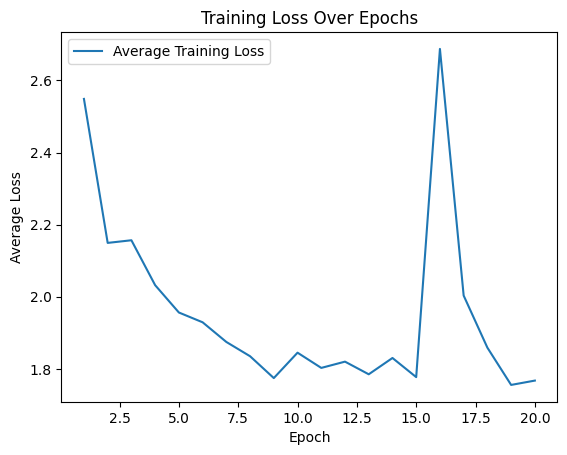

In [8]:
# Training the model
n_total_steps = len(trainloader)
avg_loss_over_epochs = []
for epoch in range(num_epochs):
    train_losses = []
    
    for i, (images, labels) in tqdm(enumerate(trainloader), desc="Training Progress", total=len(trainloader)):
        # Move images and labels to device
        images = torch.stack(images).float()
        images = images.permute(1, 0, 2, 3, 4)  # Change shape to [5, 10, 1, 224, 224]
        labels = labels.float()

        # Forward pass with autograd
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

        # Backward pass and optimization
        optimizer.zero_grad()
        fabric.backward(loss)
        optimizer.step()
        # Store the loss
        train_losses.append(loss.item())
    # Store the loss for this epoch
    avg_loss_over_epochs.append(sum(train_losses)/len(train_losses))
# Plot loss over epochs
plt.figure()
plt.plot(range(1, num_epochs + 1), avg_loss_over_epochs, label='Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Training Loss Over Epochs')
plt.show()
    

In [9]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Test the model
model.eval()
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=10)
testloader = fabric.setup_dataloaders(testloader)
test_losses = []
all_labels = []
all_outputs = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Testing Progress"):
        images = torch.stack(images).float()
        images = images.permute(1, 0, 2, 3, 4)
        labels = labels.float()
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

avg_test_loss = sum(test_losses) / len(test_losses)
rmse = math.sqrt(avg_test_loss)
mse = mean_squared_error(all_labels, all_outputs)
mae = mean_absolute_error(all_labels, all_outputs)
r2 = r2_score(all_labels, all_outputs)

print(f'Average test loss: {avg_test_loss:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

Testing Progress:   0%|          | 0/103 [00:00<?, ?it/s]

Average test loss: 2.1534
RMSE: 1.4674
MSE: 2.1626
MAE: 1.0374
R²: -0.1873


In [1]:
plt.figure(figsize=(20, 6))
plt.plot(all_labels, 'o-', label='Actual Labels')
plt.plot(all_outputs, 'x-', label='Predicted Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label Value')
plt.title('Overlay of Predicted and Actual Labels')
plt.legend()
plt.show()
print(all_outputs)

NameError: name 'plt' is not defined